In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import init
from torch import Tensor
import xlrd
import numpy as np
from math import sqrt
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import math
import random as rd
import calendar
from torch.autograd import Variable
from sklearn.preprocessing import minmax_scale 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn import preprocessing
import csv
import tensorflow
from tensorflow.keras.layers import LSTM,Embedding
from tensorflow.keras.layers import Dense, Dropout, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization

# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
#kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.001),recurrent_regularizer=l2(0.0001)

In [2]:
def insert(df, i, df_add):
    df1 = df.iloc[:i, :]
    df2 = df.iloc[i:, :]
    df_new = pd.concat([df1, df_add, df2], ignore_index=True)
    return df_new
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 大安高工停車場_LSTM

In [3]:
Da_data = pd.read_csv('data_大安高工.csv')
Da_wea = pd.read_csv('Son_data.csv')

In [4]:
Da_data = Da_data.rename(columns={'Unnamed: 0': '時間'}) 
Da_wea = Da_wea.drop(columns={'Unnamed: 0'}) 

In [5]:
Da_wea.isnull().sum()

日期      0
測站      0
觀測時間    0
測站氣壓    0
氣溫      0
相對溼度    0
降水量     0
dtype: int64

In [6]:
tor=Da_wea.loc[Da_wea['觀測時間']==24.0]
dawea = Da_wea.drop(Da_wea[Da_wea['觀測時間']==24.0].index)

In [7]:
for i in range(0,365):
    dawea=insert(dawea,23*i,tor.iloc[[i,]])

In [8]:

dawea=dawea[['測站氣壓','氣溫','相對溼度','降水量']]
scaler = MinMaxScaler(feature_range=(0, 1)).fit(dawea)
X_scaled = scaler.transform(dawea) #天氣資訊歸一化

In [9]:
Dawea = pd.DataFrame(X_scaled)
Dawea.columns = ['測站氣壓','氣溫','相對溼度','降水量']

In [10]:
Da_all = pd.concat([Da_data,Dawea],axis=1)

In [11]:
weak=pd.get_dummies(Da_all['星期幾'])
Da_all=Da_all.drop(labels=['星期幾'],axis='columns')

In [12]:
Da_all=pd.concat([Da_all,weak],axis=1)
Da_all['Time']=Da_all['時間'].str.split(' ').str.get(1)

In [13]:
Da_all=Da_all[['時間','Time', '停留時間(秒)', '進場數量', '出場數量', '時段停車數', '週轉率', '使用率', '停車延時', '測站氣壓',
       '氣溫', '相對溼度', '降水量', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday']]

In [14]:
Da_all = Da_all.join(pd.get_dummies(Da_all.Time))
Da_all=Da_all.drop(labels=['Time'],axis='columns')

In [15]:
scale = StandardScaler() #z-scaler物件
scale_param = scale.fit(Da_all['停留時間(秒)'].values.reshape(-1, 1))
Da_all['停留時間(秒)'] = scale.fit_transform(Da_all['停留時間(秒)'].values.reshape(-1, 1),scale_param)

In [16]:
Da_all.columns

Index(['時間', '停留時間(秒)', '進場數量', '出場數量', '時段停車數', '週轉率', '使用率', '停車延時', '測站氣壓',
       '氣溫', '相對溼度', '降水量', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', '00:00:00', '01:00:00', '02:00:00',
       '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00',
       '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
       '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00'],
      dtype='object')

In [107]:
Da_all

,時間,停留時間(秒),進場數量,出場數量,時段停車數,週轉率,使用率,停車延時,測站氣壓,氣溫,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,2020-04-01 00:00:00,40.970907,2.0,0.0,2,0.003883,0.002330,1.200000,0.649682,0.327815,...,0,0,0,0,0,0,0,0,0,0
1,2020-04-01 01:00:00,-0.469281,0.0,0.0,2,0.003883,0.003883,2.000000,0.429936,0.430464,...,0,0,0,0,0,0,0,0,0,0
2,2020-04-01 02:00:00,-0.469281,0.0,0.0,2,0.003883,0.003883,2.000000,0.449045,0.407285,...,0,0,0,0,0,0,0,0,0,0
3,2020-04-01 03:00:00,-0.469281,0.0,0.0,2,0.003883,0.003883,2.000000,0.452229,0.384106,...,0,0,0,0,0,0,0,0,0,0
4,2020-04-01 04:00:00,-0.469281,0.0,0.0,2,0.003883,0.003883,2.000000,0.477707,0.377483,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-03-31 19:00:00,-0.286133,31.0,39.0,87,0.244660,0.162714,83.797778,0.270701,0.589404,...,0,0,0,0,0,1,0,0,0,0
8756,2021-03-31 20:00:00,-0.322868,10.0,30.0,67,0.188350,0.139382,71.781667,0.264331,0.592715,...,0,0,0,0,0,0,1,0,0,0
8757,2021-03-31 21:00:00,-0.353229,3.0,41.0,29,0.135922,0.076705,39.503056,0.264331,0.569536,...,0,0,0,0,0,0,0,1,0,0
8758,2021-03-31 22:00:00,-0.356271,2.0,22.0,9,0.060194,0.025547,13.156667,0.283439,0.566225,...,0,0,0,0,0,0,0,0,1,0


# delete hashtag when executing LSTM (df_val)

In [17]:
df_train = Da_all[Da_all['時間']<'2021-01-01 00:00:00'].reset_index()
#df_val =  Da_all[(Da_all['時間']>='2021-01-01 00:00:00') & (Da_all['時間']<'2021-02-01 00:00:00')].reset_index()
df_test = Da_all[(Da_all['時間']>='2021-01-01 00:00:00') & (Da_all['時間']<'2021-04-01 00:00:00')].reset_index()


In [18]:
df_train=df_train.drop(labels=['時間'],axis='columns')
#df_val = df_val.drop(labels=['時間'],axis='columns')
df_test = df_test.drop(labels=['時間'],axis='columns')

In [19]:
df_train['rank'] = df_train["index"].rank().astype(int)
#df_val['rank'] = df_val["index"].rank().astype(int)
df_test['rank'] = df_test["index"].rank().astype(int)

In [20]:
df_train=df_train.drop(labels=['index'],axis='columns')
#df_val = df_val.drop(labels=['index'],axis='columns')
df_test = df_test.drop(labels=['index'],axis='columns')

In [21]:
X_train = df_train.iloc[:,:44]
y_train =df_train.iloc[:,3]

In [22]:
X_test = df_test.iloc[:,:44]

In [23]:
y_test =df_test.iloc[:,3]

In [24]:
X_train=X_train[['停留時間(秒)',  '週轉率', '使用率', '測站氣壓', '氣溫',
       '相對溼度', '降水量', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', '00:00:00', '01:00:00', '02:00:00',
       '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00',
       '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
       '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00']]

In [25]:
X_test=X_test[['停留時間(秒)',  '週轉率', '使用率', '測站氣壓', '氣溫',
       '相對溼度', '降水量', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', '00:00:00', '01:00:00', '02:00:00',
       '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00',
       '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
       '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00']]

In [26]:
#X_train = X_train.values
#y_train = y_train.values
#X_test = X_test.values
#y_test =  y_test.values

# XGBoost

In [67]:

#xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, min_child_weight=5, max_depth=4)
xgb = XGBRegressor(n_estimators=209, learning_rate=0.1,min_child_weight=5, max_depth=4 )
model = xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)


print('MSE:%.3f' %mean_squared_error(y_test, y_pred))
#print('R^2:%.3f' %r2_score(y_test, y_pred))
print('MAE:%.3f' %mean_absolute_error(y_test, y_pred))
y_test.index = range(len(y_test))
d = pd.concat([y_test, pd.DataFrame(y_pred, columns=['預測停車數量'])], axis = 1)
d['差異'] = d['預測停車數量'] - d['時段停車數']
d2 = d[d['時段停車數']!=0]
print('MAPE:',mape(np.array(d2['時段停車數']), np.array(d2['預測停車數量'])))


MSE:11.241
MAE:2.183
MAPE: 3.5085872241912455


In [71]:

# feature importance
print(xgb.feature_importances_)
# plot feature importance
pyplot.rcParams['font.sans-serif'] = ['Arial Unicode MS']


[9.5198612e-04 4.7772275e-03 8.4090954e-01 4.3895151e-04 3.1370667e-04
 4.0354597e-04 3.7636698e-04 5.4913759e-04 5.2205467e-04 6.1156676e-04
 5.1681401e-04 4.4873057e-04 6.3059904e-04 4.6840197e-04 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0981441e-04 8.0644116e-03 2.4682675e-02 1.7098689e-02 8.7734424e-03
 9.1760955e-04 1.4942617e-03 4.5221429e-03 3.6896723e-03 1.9199925e-03
 8.1443619e-03 8.4614949e-03 2.9253040e-04 5.2766415e-04 1.5627269e-02
 4.1854940e-02 1.7181663e-03 1.8229052e-04]


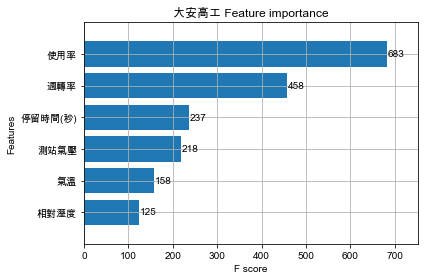

In [106]:

fig=plot_importance(xgb,
                height=0.8,
                max_num_features=6,).figure
pyplot.title('大安高工 Feature importance')
pyplot.tight_layout()
fig.savefig('大安高工.png',dpi=200)

In [57]:
xgb.get_booster().get_score(importance_type='weight')


{'使用率': 688,
 '21:00:00': 31,
 '週轉率': 461,
 '08:00:00': 45,
 '09:00:00': 75,
 '17:00:00': 56,
 '07:00:00': 25,
 '20:00:00': 45,
 '10:00:00': 58,
 '16:00:00': 46,
 '停留時間(秒)': 237,
 '22:00:00': 25,
 'Tuesday': 18,
 '13:00:00': 22,
 '測站氣壓': 218,
 '氣溫': 161,
 'Friday': 30,
 '相對溼度': 127,
 '12:00:00': 30,
 '15:00:00': 30,
 '14:00:00': 11,
 '11:00:00': 25,
 'Sunday': 36,
 '降水量': 32,
 'Saturday': 31,
 'Monday': 20,
 'Thursday': 15,
 '23:00:00': 10,
 '18:00:00': 26,
 '19:00:00': 17,
 'Wednesday': 13,
 '06:00:00': 3}

In [602]:
Da_data2=Da_data[(Da_data['時間']>='2021-01-01 00:00:00') & (Da_data['時間']<'2021-04-01 00:00:00')].reset_index()

In [603]:
Da_all = pd.concat([Da_data2,d[['預測停車數量']]],axis=1)

In [605]:
Da_all = Da_all[['時間','預測停車數量']]
Da_all.to_csv('/Users/julia/Desktop/海量研究室/停車場競賽/預測停車場數/大安預測停車數_test.csv')

# LSTM

In [21]:
def process_data(df_train,df_val,df_test,pastDay,futureDay):   
    feature = ['停留時間(秒)', '週轉率', '使用率', '停車延時', '氣溫',
       '相對溼度', '風速', '降水量', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', '00:00:00', '01:00:00', '02:00:00',
       '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00',
       '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
       '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00']
    target = '時段停車數'
    
    train_feature = np.array(df_train[feature])
    train_flow = np.array(df_train[target])
    train_rank = np.array(df_train['rank'])
    
    val_feature = np.array(df_val[feature])
    val_flow = np.array(df_val[target])
    val_rank = np.array(df_val['rank'])
    
    test_feature = np.array(df_test[feature])
    test_flow = np.array(df_test[target])
    test_rank = np.array(df_test['rank'])
    

    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

    for i in tqdm_notebook(range(pastDay, len(train_feature))):
        if train_rank[i] > pastDay:
            X_train.append(train_feature[i - pastDay: i])
            y_train.append(train_flow[i:i+futureDay])
        else:
            pass
    
    for i in tqdm_notebook(range(pastDay, len(val_feature))):
        if val_rank[i] > pastDay:
            X_val.append(val_feature[i - pastDay: i])
            y_val.append(val_flow[i:i+futureDay])
        else:
            pass

    for i in tqdm_notebook(range(pastDay, len(test_feature))):
        if test_rank[i] > pastDay:
            X_test.append(test_feature[i - pastDay: i])
            y_test.append(test_flow[i:i+futureDay])
        else:
            pass

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print("X_train_shape:",X_train.shape)
    print("y_train_shape:",y_train.shape)
    print("X_val_shape:",X_val.shape)
    print("y_val_shape:",y_val.shape)
    print("X_test:",X_test.shape)
    print("y_test:",y_test.shape)

    return X_train, y_train, X_val, y_val,  X_test, y_test #, random_index

In [22]:
pastTime = 2
futureTime = 1

In [23]:
X_train, y_train, X_val, y_val, X_test, y_test = process_data(df_train,df_val, df_test,pastTime ,futureTime)

<ipython-input-21-39f6e0dd66da>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(pastDay, len(train_feature))):


  0%|          | 0/6598 [00:00<?, ?it/s]

<ipython-input-21-39f6e0dd66da>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(pastDay, len(val_feature))):


  0%|          | 0/742 [00:00<?, ?it/s]

<ipython-input-21-39f6e0dd66da>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(pastDay, len(test_feature))):


  0%|          | 0/1414 [00:00<?, ?it/s]

X_train_shape: (6598, 2, 39)
y_train_shape: (6598, 1)
X_val_shape: (742, 2, 39)
y_val_shape: (742, 1)
X_test: (1414, 2, 39)
y_test: (1414, 1)


In [39]:
model = tensorflow.keras.Sequential()
def get_lstm(X_shape):
    model = Sequential()
    model.add(LSTM(20, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
    model.add(Dropout(0.1))
    
    model.add(LSTM(16,activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(units = 1))
    return model



adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = get_lstm(X_train.shape)
model.compile(loss='mae', optimizer=adam)
print(model.summary())

/Users/julia/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 2, 20)             4800      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 20)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2368      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 7,185
Trainable params: 7,185
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
import time
start = time.perf_counter() 
hist = model.fit(X_train, y_train,batch_size=20,epochs=200,validation_data=(X_val, y_val)) 
elapsed = (time.perf_counter()  - start)
print("Time used:",elapsed)

Epoch 1/200
330/330 [==============================] - 3s 3ms/step - loss: 32.4914 - val_loss: 15.0224
Epoch 2/200
330/330 [==============================] - 1s 2ms/step - loss: 13.2891 - val_loss: 9.0158
Epoch 3/200
330/330 [==============================] - 1s 2ms/step - loss: 10.6912 - val_loss: 9.1922
Epoch 4/200
330/330 [==============================] - 1s 3ms/step - loss: 10.3919 - val_loss: 7.1049
Epoch 5/200
330/330 [==============================] - 1s 2ms/step - loss: 9.6406 - val_loss: 7.1654
Epoch 6/200
330/330 [==============================] - 1s 2ms/step - loss: 9.2650 - val_loss: 7.5027
Epoch 7/200
330/330 [==============================] - 1s 2ms/step - loss: 9.2408 - val_loss: 5.9380
Epoch 8/200
330/330 [==============================] - 1s 2ms/step - loss: 9.0128 - val_loss: 8.6359
Epoch 9/200
330/330 [==============================] - 1s 2ms/step - loss: 8.9435 - val_loss: 6.6698
Epoch 10/200
330/330 [==============================] - 1s 2ms/step - loss: 8.8012 - v

Epoch 161/200
330/330 [==============================] - 1s 2ms/step - loss: 6.4243 - val_loss: 5.6462
Epoch 162/200
330/330 [==============================] - 1s 2ms/step - loss: 6.2784 - val_loss: 6.7329
Epoch 163/200
330/330 [==============================] - 1s 2ms/step - loss: 6.2974 - val_loss: 9.7557
Epoch 164/200
330/330 [==============================] - 1s 2ms/step - loss: 6.3148 - val_loss: 9.5847
Epoch 165/200
330/330 [==============================] - 1s 3ms/step - loss: 6.3816 - val_loss: 9.4917
Epoch 166/200
330/330 [==============================] - 1s 2ms/step - loss: 6.2897 - val_loss: 7.4350
Epoch 167/200
330/330 [==============================] - 1s 2ms/step - loss: 6.2361 - val_loss: 7.6425
Epoch 168/200
330/330 [==============================] - 1s 2ms/step - loss: 6.3318 - val_loss: 6.5287
Epoch 169/200
330/330 [==============================] - 1s 2ms/step - loss: 6.3224 - val_loss: 7.3910
Epoch 170/200
330/330 [==============================] - 1s 2ms/step - lo

In [41]:
def Saveplot(history):
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.plot(history.epoch, history.history['loss'], 'red', lw=2,  label = 'Training')
    plt.plot(history.epoch, history.history['val_loss'], 'blue', lw=2, label = 'Validation')

    plt.legend()
    plt.show()

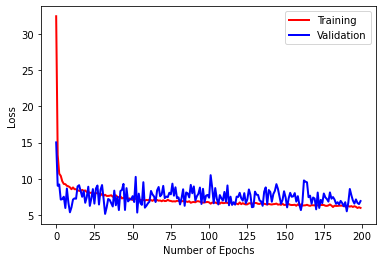

In [42]:
Saveplot(hist)

In [44]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [ ]:
print('MAE test:%.6f' % mean_absolute_error (np.array(y_test),np.array(testPredict)))

In [48]:
df1=pd.DataFrame(testPredict)
df2=pd.DataFrame(y_test)

In [49]:
alldf = pd.concat([df2,df1],axis=1)
alldf.columns=['實際停車數','預測停車數']
alldf['差異']=alldf['預測停車數']-alldf['實際停車數']

In [51]:
d2 = alldf[alldf['實際停車數']!=0]

In [52]:
print(mape(np.array(d2['實際停車數']), np.array(d2['預測停車數'])))

10.630662407009952


# 峨眉停車場

In [81]:
Me_data = pd.read_csv('data_峨眉汽車.csv')
Me_wea = pd.read_csv('Taipei_data.csv')

In [82]:
Me_data = Me_data.rename(columns={'Unnamed: 0': '時間'}) 
Me_wea = Me_wea.drop(columns={'Unnamed: 0'}) 

In [83]:
tor2=Me_wea.loc[Me_wea['觀測時間']==24.0]
mewea = Me_wea.drop(Me_wea[Me_wea['觀測時間']==24.0].index)

In [84]:
for i in range(0,365):
    mewea=insert(mewea,23*i,tor2.iloc[[i,]])

In [85]:
mewea=mewea[['測站氣壓','氣溫','相對溼度','風速','風向','降水量']]
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(mewea)
X_scaled2 = scaler2.transform(mewea) #天氣資訊歸一化

In [86]:
Mewea = pd.DataFrame(X_scaled2)

In [87]:
Mewea.columns = ['測站氣壓','氣溫','相對溼度','風速','風向','降水量']
Me_all = pd.concat([Me_data,Mewea],axis=1)
weak2 =pd.get_dummies(Me_all['星期幾'])
Me_all=Me_all.drop(labels=['星期幾'],axis='columns')
Me_all=pd.concat([Me_all,weak2],axis=1)

Me_all['Time']=Me_all['時間'].str.split(' ').str.get(1)
Me_all=Me_all[['時間','Time', '停留時間(秒)', '進場數量', '出場數量', '時段停車數', '週轉率', '使用率', '停車延時', '測站氣壓',
       '氣溫', '相對溼度', '風速', '風向', '降水量', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday']]
Me_all = Me_all.join(pd.get_dummies(Me_all.Time))
Me_all=Me_all.drop(labels=['Time'],axis='columns')

scale = StandardScaler() #z-scaler物件
scale_param2 = scale.fit(Me_all['停留時間(秒)'].values.reshape(-1, 1))
Me_all['停留時間(秒)'] = scale.fit_transform(Me_all['停留時間(秒)'].values.reshape(-1, 1),scale_param2)

# delete hashtag when executing LSTM (df2_val)

In [88]:
df2_train = Me_all[Me_all['時間']<'2021-01-01 00:00:00'].reset_index()
#df2_val =  Me_all[(Me_all['時間']>='2021-01-01 00:00:00') & (Me_all['時間']<'2021-02-01 00:00:00')].reset_index()
df2_test = Me_all[(Me_all['時間']>='2021-01-01 00:00:00') & (Me_all['時間']<'2021-04-01 00:00:00')].reset_index()

df2_train=df2_train.drop(labels=['時間'],axis='columns')
#df2_val = df2_val.drop(labels=['時間'],axis='columns')
df2_test = df2_test.drop(labels=['時間'],axis='columns')

df2_train['rank'] = df2_train["index"].rank().astype(int)
#df2_val['rank'] = df2_val["index"].rank().astype(int)
df2_test['rank'] = df2_test["index"].rank().astype(int)

df2_train=df2_train.drop(labels=['index'],axis='columns')
#df2_val = df2_val.drop(labels=['index'],axis='columns')
df2_test = df2_test.drop(labels=['index'],axis='columns')

# LSTM

In [89]:
X2_train, y2_train, X2_val, y2_val, X2_test, y2_test = process_data(df2_train,df2_val, df2_test,pastTime ,futureTime)

NameError: name 'process_data' is not defined

In [64]:
model = tensorflow.keras.Sequential()
def get_lstm(X_shape):
    model = Sequential()
    model.add(LSTM(20, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
    model.add(Dropout(0.1))
    
    model.add(LSTM(16,activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(units = 1))
    return model


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_2 = get_lstm(X2_train.shape)
model_2.compile(loss='mae', optimizer=adam)
print(model_2.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 2, 20)             4800      
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 20)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                2368      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 7,185
Trainable params: 7,185
Non-trainable params: 0
_________________________________________________________________
None


/Users/julia/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [65]:
import time
start = time.perf_counter() 
hist2 = model_2.fit(X2_train, y2_train,batch_size=20,epochs=200,validation_data=(X2_val, y2_val)) 
elapsed = (time.perf_counter()  - start)
print("Time used:",elapsed)


Epoch 1/200
330/330 [==============================] - 3s 3ms/step - loss: 101.3661 - val_loss: 36.6034
Epoch 2/200
330/330 [==============================] - 1s 2ms/step - loss: 44.4561 - val_loss: 27.8800
Epoch 3/200
330/330 [==============================] - 1s 2ms/step - loss: 41.4003 - val_loss: 35.6545
Epoch 4/200
330/330 [==============================] - 1s 2ms/step - loss: 39.4802 - val_loss: 30.7135
Epoch 5/200
330/330 [==============================] - 1s 2ms/step - loss: 38.6200 - val_loss: 39.3254
Epoch 6/200
330/330 [==============================] - 1s 2ms/step - loss: 37.2297 - val_loss: 38.9078
Epoch 7/200
330/330 [==============================] - 1s 2ms/step - loss: 35.7089 - val_loss: 27.4773
Epoch 8/200
330/330 [==============================] - 1s 2ms/step - loss: 35.8925 - val_loss: 26.8946
Epoch 9/200
330/330 [==============================] - 1s 2ms/step - loss: 33.7905 - val_loss: 29.3155
Epoch 10/200
330/330 [==============================] - 1s 2ms/step - lo

Epoch 80/200
330/330 [==============================] - 1s 2ms/step - loss: 24.6990 - val_loss: 41.6768
Epoch 81/200
330/330 [==============================] - 1s 2ms/step - loss: 25.1035 - val_loss: 37.9490
Epoch 82/200
330/330 [==============================] - 1s 2ms/step - loss: 23.5379 - val_loss: 18.7860
Epoch 83/200
330/330 [==============================] - 1s 3ms/step - loss: 24.6492 - val_loss: 33.6739
Epoch 84/200
330/330 [==============================] - 1s 2ms/step - loss: 24.8444 - val_loss: 29.0617
Epoch 85/200
330/330 [==============================] - 1s 3ms/step - loss: 24.4819 - val_loss: 33.7037
Epoch 86/200
330/330 [==============================] - 1s 2ms/step - loss: 23.8892 - val_loss: 36.4740
Epoch 87/200
330/330 [==============================] - 1s 2ms/step - loss: 24.2677 - val_loss: 30.5013
Epoch 88/200
330/330 [==============================] - 1s 2ms/step - loss: 24.0447 - val_loss: 27.9272
Epoch 89/200
330/330 [==============================] - 1s 2ms/s

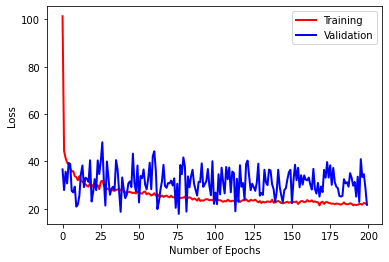

In [66]:
Saveplot(hist2)

In [67]:
trainPredict2 = model_2.predict(X2_train)
testPredict2 = model_2.predict(X2_test)

In [68]:
print('MAE test:%.6f' % mean_absolute_error (y2_test,testPredict2))

MAE test:27.302231


In [69]:
df11=pd.DataFrame(testPredict2)
df22=pd.DataFrame(y2_test)

In [70]:
alldf2 = pd.concat([df22,df11],axis=1)

In [71]:
alldf2.columns=['實際停車數','預測停車數']

In [72]:
alldf2['差異']=alldf2['預測停車數']-alldf2['實際停車數']

In [73]:
d3 = alldf2[alldf2['實際停車數']!=0]

In [74]:
print(mape(np.array(d3['實際停車數']), np.array(d3['預測停車數'])))

9.180712151431072


# XGBoost

In [90]:
X2_train = df2_train.iloc[:,:44]

In [91]:
X2_train=X2_train[['停留時間(秒)',  '週轉率', '使用率', '停車延時', '測站氣壓', '氣溫',
       '相對溼度', '降水量', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', '00:00:00', '01:00:00', '02:00:00',
       '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00',
       '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
       '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00']]

In [92]:
y2_train = df2_train.iloc[:,3]

In [93]:
X2_test = df2_test.iloc[:,:44]

In [94]:
X2_test=X2_test[['停留時間(秒)',  '週轉率', '使用率', '停車延時', '測站氣壓', '氣溫',
       '相對溼度', '降水量', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', '00:00:00', '01:00:00', '02:00:00',
       '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00',
       '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
       '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00']]

In [95]:
y2_test = df2_test.iloc[:,3]

In [100]:
from xgboost import XGBRegressor

#xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, min_child_weight=5, max_depth=4)
xgb2 = XGBRegressor(n_estimators=209, learning_rate=0.1, min_child_weight=5, max_depth=4)
xgb2.fit(X2_train,y2_train)
y2_pred = xgb2.predict(X2_test)


print('MSE:%.3f' %mean_squared_error(y2_test, y2_pred))
#print('R^2:%.3f' %r2_score(y_test, y_pred))
print('MAE:%.3f' %mean_absolute_error(y2_test, y2_pred))

y2_test.index = range(len(y2_test))
d_all = pd.concat([y2_test, pd.DataFrame(y2_pred, columns=['預測停車數量'])], axis = 1)
d_all['差異'] = d_all['預測停車數量'] - d_all['時段停車數']
d2_all = d_all[d_all['時段停車數']!=0]
print('MAPE:',mape(np.array(d2_all['時段停車數']), np.array(d2_all['預測停車數量'])))

MSE:194.858
MAE:7.010
MAPE: 2.773201249687446


In [101]:

# feature importance
print(xgb2.feature_importances_)
# plot feature importance
pyplot.rcParams['font.sans-serif'] = ['Arial Unicode MS']


[3.3598318e-04 3.0545359e-03 8.7968183e-01 0.0000000e+00 1.5580395e-04
 2.0684094e-04 1.5579558e-04 1.1824866e-04 4.1361977e-04 7.2829927e-05
 3.7521671e-04 8.8542578e-04 3.0360281e-04 1.0686302e-04 1.8244555e-04
 6.1046233e-04 2.0742712e-04 4.2817646e-05 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.7298087e-04 3.3010419e-03 4.4326819e-03
 7.4989847e-03 1.7193941e-02 1.3793523e-02 3.2899564e-03 1.0396726e-03
 3.7265060e-04 1.7952383e-03 4.9554225e-04 3.9883195e-03 2.2122837e-03
 7.7939657e-03 2.4717106e-02 1.7984195e-02 3.0082825e-03]


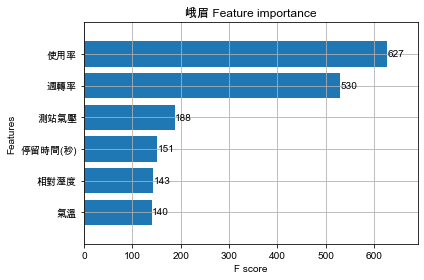

In [105]:

fig2 = plot_importance(xgb2,
                height=0.8,
                max_num_features=6).figure


pyplot.title('峨眉 Feature importance')
pyplot.tight_layout()
fig2.savefig('峨眉.png',dpi=200)

In [94]:
y2_train

0         4
1         4
2         4
3         4
4         5
       ... 
6595    551
6596    567
6597    519
6598    400
6599    312
Name: 時段停車數, Length: 6600, dtype: int64

In [616]:
d_all['差異'].min()

-257.96466064453125

In [511]:
Me_pre=d_all[['預測停車數量']]

In [ ]:
Me_data2=Me_data[(Me_data['時間']>='2021-01-01 00:00:00') & (Me_data['時間']<'2021-04-01 00:00:00')].reset_index()

In [525]:
Me_all= pd.concat([Me_data2,Me_pre],axis=1)

In [526]:
Me_all=Me_all[['時間','預測停車數量']]

In [528]:
Me_all.to_csv('/Users/julia/Desktop/海量研究室/停車場競賽/預測停車場數/峨眉預測停車數_test.csv')

In [395]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import time
import pandas as pd

options = webdriver.ChromeOptions()

browser = webdriver.Chrome(r'/Users/julia/Downloads/chromedriver', options=options)

url = "https://www.google.com.tw/maps/place/%E7%93%A6%E5%9F%8E%E5%A4%A7%E5%BF%83(%E5%8F%B0%E4%B8%AD%E6%96%B0%E5%85%89%E4%B8%89%E8%B6%8A%E5%BA%97%EF%BC%89/@24.2335548,120.4303719,10z/data=!4m11!1m2!2m1!1z55Om5Z-O!3m7!1s0x34693d8cb70d7dff:0xe2ec5d39880378a7!8m2!3d24.1652572!4d120.6437083!9m1!1b1!15sCgbnk6bln44iA4gBAVoJIgfnk6Yg5Z-OkgEPdGhhaV9yZXN0YXVyYW50mgEjQ2haRFNVaE5NRzluUzBWSlEwRm5TVVJqTVhJdFZVRm5FQUU?hl=zh-TW"

browser.implicitly_wait(2)
browser.get(url)



In [384]:
tmp = browser.find_elements_by_xpath("//div[@class='ODSEW-ShBeI-content']")
len(tmp) #每一頁有八個評論

8

In [399]:
while len(tmp) < int(43): #評論總數減6
    browser.execute_script('''
        const body = document.querySelector
        (‘div.section-layout.section-scrollbox.cYB2Ge-oHo7ed.cYB2Ge-ti6hGc’);   
        body.scrollTo(0, body.scrollHeight);
    ''')  
    # execute_script ：為執行JavaScript 程式碼
    # const ：宣告常數 （在這裡宣告了body之值）
    # querySelector 回傳document第一個符合特定選擇器群組的元素，其字串參數必須遵循 CSS 語法
    # 透過觀察的方式可以發現，當網頁滾動到最底部的時候會自動加載更多留言，body.scrollTo(0, body.scrollHeight) 為滾動到最底部

    time.sleep(0.5) #暫停執行0.5秒

    tmp = browser.find_elements_by_xpath("//div[@class='ODSEW-ShBeI-content']")

JavascriptException: Message: javascript error: Invalid or unexpected token
  (Session info: chrome=92.0.4515.159)


In [ ]:

soup = BeautifulSoup(browser.page_source, 'html.parser') 
reviewer = soup.find_all('div', {'class': 'ODSEW-ShBeI-title'})
stars = soup.find_all('span', {'class': 'ODSEW-ShBeI-H1e3jb'})
contents = soup.find_all('span', {'class': 'ODSEW-ShBeI-text'})

name = []
score = []
review_text = []

for r_name in reviewer:
    name.append(r_name.text)

for rating in stars:
    score.append(rating['aria-label'])
    
for review in contents:
    review_text.append(review.text)

all_data = list(zip(name, score, review_text))

df = pd.DataFrame(all_data, columns = ['評論者' , '評價分數', '評論內容'])

df.to_csv('review.csv', index=False)
